In [167]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import pandas as pd
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 12,
    "figure.dpi": 150})

# MCMC functions

In [168]:
def lnprior(theta,lims):
    lnpr = np.zeros(len(theta))
    for i in range(len(theta)):
        if(lims[i][0] < theta[i] and theta[i] < lims[i][1]):
            lnpr[i] = -1*np.log(1/(lims[i][1]-lims[i][0]))
        else:
            lnpr[i] = -1*np.inf
    return sum(lnpr)

def lnlikelihood(data, theta, model, dev=0):
    if(np.any(dev != 0)):
        dev = np.ones(len(data[0]))
    return -1/2*np.sum(((data[1] - model(data[0],theta))/dev)**2)

def mcmc(data, model, lims_prior, dispersion_trial, theta_start = [0,0], n_steps=250, max_it=1000, dev=0):
    theta_chain = [theta_start]
    lnposterior_i = lnlikelihood(data, theta_chain[-1:][0], model, dev=dev) + lnprior(theta_chain[-1:][0],lims_prior)
    it = 0
    while (len(theta_chain) < n_steps and it < max_it):
        it += 1
        theta_i = theta_chain[-1:][0]
        theta_trial = np.random.normal(theta_i,dispersion_trial)
        lnposterior_trial = lnlikelihood(data, theta_trial, model, dev=dev) + lnprior(theta_trial,lims_prior)
        p_acc = min(1,np.exp(lnposterior_trial-lnposterior_i))
        if(p_acc > np.random.uniform()):
            theta_chain.append(theta_trial)
            lnposterior_i = lnposterior_trial
    return np.array(theta_chain).T


# My $\mu(z)$ model functions

In [169]:
# km/s/Mpc units
h_0 = 67.36

# 1/Gyr units
h_0 = h_0*(1/3.086e+19)*(60*60*24*365)

# integral resolution
resolution = 1000

In [170]:
# function a' = f(t,a) (L-CDM model)
def adot_lcdm(a,params):
    return h_0*np.sqrt(params[0]*a**(-1) + params[1]*a**(2) + params[2]*a**(-2))

# numerical integration simpson's method 
def integral_simpson(f,t):
    t_new = []
    integral = []
    integral_sum = 0
    for i in range(len(t)-1):
        t_new_point = (t[i] + t[i+1])/2
        t_new.append(t_new_point)
        integral_sum += (t[i+1] - t[i])*(f[i+1] + f[i])/2
        integral.append(integral_sum)
    return np.array(integral), np.array(t_new)

# distance modulus function
def mu_z(om_m0, om_l0):
    # make sure the sum of parameters equals 1
    params = [om_m0, om_l0, 1-(om_m0 + om_l0)]
    
    # compute proper distance
    #z = np.linspace(0.0005,2.0005,20001)
    z = np.linspace(5/resolution,2 + 5/resolution,resolution*2 + 1)
    a = 1/(z+1)
    f = a/(adot_lcdm(a,params))
    d_pt0, z_new = integral_simpson(f,z)

    # c factor missing after integration
    c = 3e8*(60*60*24*365)*(1/3.086e+22)
    d_pt0 = c*d_pt0

    # compute luminosity distance
    d_l = d_pt0*(1 + z_new)

    # compute the distance modulus
    mu = 5*np.log10(d_l) + 25
    
    return mu, z_new

# Interpolation of discrete mu function
def mu_inter(z_arg, om):
    om_m0 = om[0]
    om_l0 = om[1]
    mu,z = mu_z(om_m0, om_l0)
    mu_interf = interp1d(z, mu, kind="linear", fill_value="extrapolate")
    return mu_interf(z_arg)

### Experimental data and my $\mu(z)$ with Planck colaboration parameters visualization

In [171]:
# density parameters L-CDM
om_g0 = 5.446e-5*1.681
om_m0 = 0.3153 - om_g0
om_l0 = 1 - (om_m0 + om_g0)

# Get L-CDM mu(z) function
mu_lcdm, z_lcdm = mu_z(om_m0, om_l0)

In [172]:
# read experimental data
df_mu = pd.read_csv("mu.csv")
z_exp = np.array(df_mu["z"])
mu_exp = np.array(df_mu["mu"])
error_exp = np.array(df_mu["error"])

experimental = np.array([z_exp, mu_exp, error_exp])

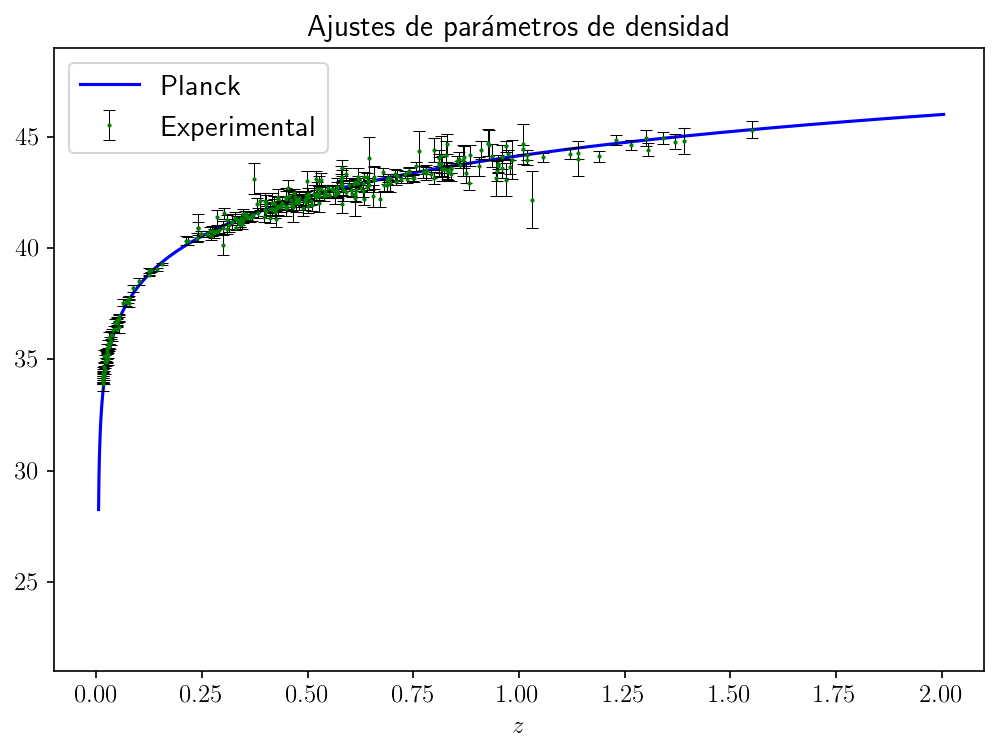

In [173]:
fig,ax = plt.subplots(figsize=(8,5.5),dpi=150)

ax.plot(z_lcdm,mu_lcdm,"b",label=r"Planck")
ax.errorbar(z_exp,mu_exp,yerr=error_exp,fmt='g.',elinewidth=0.5,capthick=0.5,capsize=3,ecolor="k",ms=2,label=r"Experimental")

ax.set_ylim(21,49)
ax.set_xlim(-0.1,2.1)

#ax.grid()
ax.set_xlabel(r"$z$")
#ax.set_ylabel(r"1/years")
ax.set_title(r"Ajustes de parámetros de densidad")
plt.legend(fontsize=14)

# MCMC run with my $\mu(z)$ function

In [174]:
n_chains = 10

chains = []

for i in range(n_chains):
    chain = mcmc(data = np.array([z_exp,mu_exp]),
                model = mu_inter,
                lims_prior = [[0,1],[0,1]],
                dispersion_trial = [0.01,0.01],
                theta_start = [np.random.uniform(0,0.5),np.random.uniform(0.5,1)],
                n_steps = 1000,
                max_it = 200000,
                dev = error_exp)
    chains.append(chain)
chains = np.array(chains)

chains_mymu = chains

C:\Users\tu_rk\AppData\Local\Temp\ipykernel_19728\1188039574.py:3: RuntimeWarning: invalid value encountered in sqrt
  return h_0*np.sqrt(params[0]*a**(-1) + params[1]*a**(2) + params[2]*a**(-2))


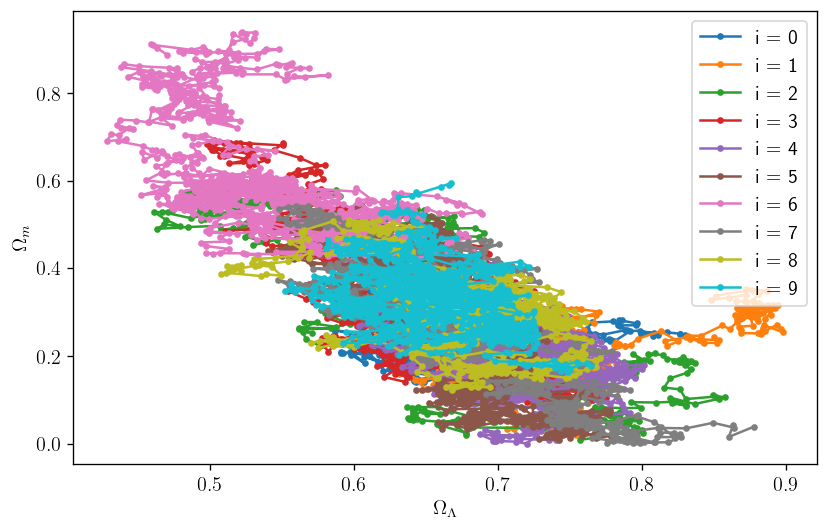

In [175]:
param_names = [r"$\Omega_m$", r"$\Omega_\Lambda$"]
fig, ax= plt.subplots(figsize=(8,5), dpi=120)
for i in range(len(chains_mymu)):
    ax.plot(chains_mymu[i][1], chains_mymu[i][0], ".-", label="i = " + str(i))
ax.set_xlabel(param_names[1])
ax.set_ylabel(param_names[0])
ax.legend()

Text(0.5, 1.0, 'Cadenas')

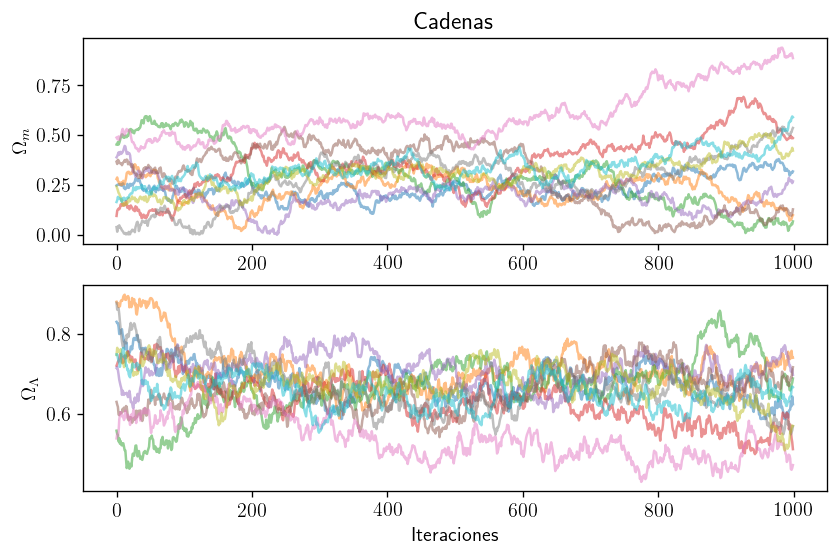

In [176]:
param_names = [r"$\Omega_m$", r"$\Omega_\Lambda$"]

fig, ax = plt.subplots(chains_mymu.shape[1],figsize=(8,5), dpi=120)
for i in range(chains_mymu.shape[1]):
    for j in range(chains_mymu.shape[0]):
        ax[i].plot(range(len(chains_mymu[j][i])),chains_mymu[j][i],alpha=0.5)
    ax[i].set_ylabel(param_names[i])

ax[i].set_xlabel('Iteraciones')
ax[0].set_title('Cadenas')

Text(0.5, 1.0, 'Cadenas sin burn')

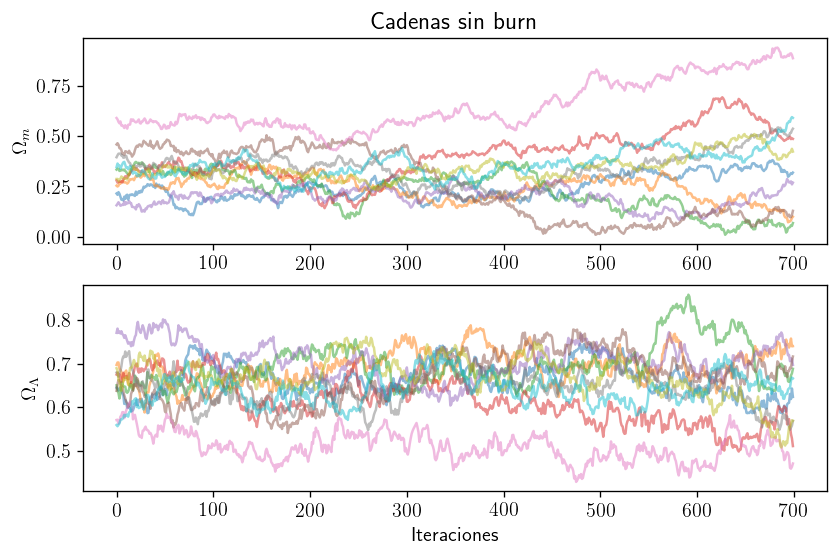

In [177]:
chains_mymu_nb = chains_mymu.T[300:].T

param_names = [r"$\Omega_m$", r"$\Omega_\Lambda$"]

fig, ax = plt.subplots(chains_mymu.shape[1],figsize=(8,5), dpi=120)
for i in range(chains_mymu.shape[1]):
    for j in range(chains_mymu.shape[0]):
        ax[i].plot(range(len(chains_mymu_nb[j][i])),chains_mymu_nb[j][i],alpha=0.5)
    ax[i].set_ylabel(param_names[i])

ax[i].set_xlabel('Iteraciones')
ax[0].set_title('Cadenas sin burn')

In [178]:
chains_mymu_concat = np.array([0,0])
for i in range(len(chains_mymu_nb)):
    chains_mymu_concat = np.vstack([chains_mymu_concat,chains_mymu_nb[i].T])
chains_mymu_concat = np.array(chains_mymu_concat[1:])

Removed no burn in


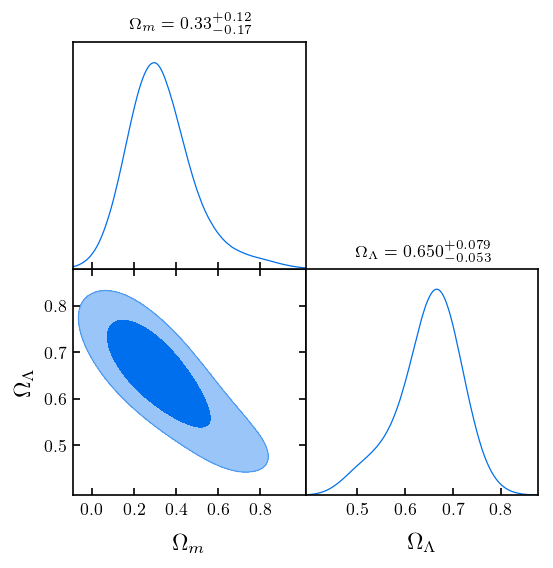

In [179]:
#Gráfica triangular
samples = MCSamples(samples=np.array(chains_mymu_concat), names=['om_m','om_l'], labels=['\Omega_m','\Omega_\Lambda'])
plt.rcParams['figure.dpi'] = 150
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True,title_limit=1)
plt.savefig('test.png', dpi = 500)

In [180]:
# density parameters L-CDM
om_m0 = samples.means[0]
om_l0 = samples.means[1]

# Get L-CDM mu(z) function
mu_fit, z_fit = mu_z(om_m0, om_l0)

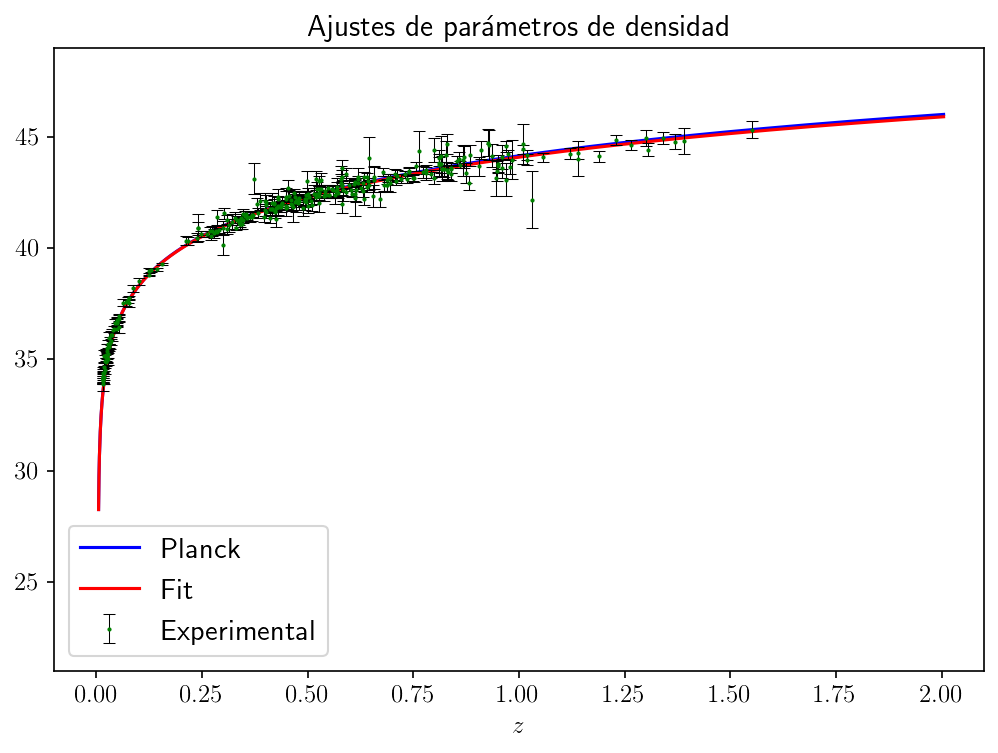

In [181]:
fig,ax = plt.subplots(figsize=(8,5.5),dpi=150)

ax.plot(z_lcdm,mu_lcdm,"b",label=r"Planck")
ax.plot(z_fit,mu_fit,"r",label=r"Fit")
ax.errorbar(z_exp,mu_exp,yerr=error_exp,fmt='g.',elinewidth=0.5,capthick=0.5,capsize=3,ecolor="k",ms=2,label=r"Experimental")

ax.set_ylim(21,49)
ax.set_xlim(-0.1,2.1)

#ax.grid()
ax.set_xlabel(r"$z$")
#ax.set_ylabel(r"1/years")
ax.set_title(r"Ajustes de parámetros de densidad")
plt.legend(fontsize=14)

# Astropy $\mu(z)$ functions

In [182]:
def lumdist(z, olambda):
  cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda,Tcmb0=2.7255)
  return  cosmo.luminosity_distance(z) 

In [183]:
def mu_astropy(z, olambda):
  DL = lumdist(z, olambda[0])   
  return 5. * np.log10(DL.value)+25

### Experimental data and astropy $\mu(z)$ with Planck colaboration parameters visualization

In [184]:
n_chains = 10

chains = []

for i in range(n_chains):
    chain = mcmc(data = np.array([z_exp,mu_exp]),
                model = mu_astropy,
                lims_prior = [[0,1]],
                dispersion_trial = 0.02,
                theta_start = [np.random.uniform(0,1)],
                n_steps = 1000,
                max_it = 200000,
                dev = error_exp)
    chains.append(chain)
chains = np.array(chains)

chains_astmu = chains


Text(0.5, 1.0, 'Cadenas')

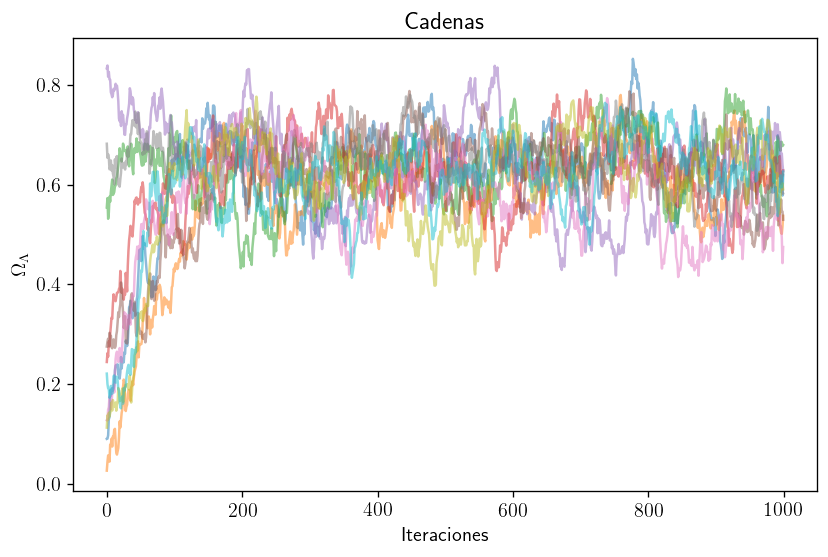

In [185]:
param_names = [r"$\Omega_\Lambda$"]

fig, ax = plt.subplots(chains_astmu.shape[1],figsize=(8,5), dpi=120)
for i in range(chains_astmu.shape[1]):
    for j in range(chains_astmu.shape[0]):
        ax.plot(range(len(chains_astmu[j][i])),chains_astmu[j][i],alpha=0.5)
    ax.set_ylabel(param_names[i])

ax.set_xlabel('Iteraciones')
ax.set_title('Cadenas')

Text(0.5, 1.0, 'Cadenas sin burn')

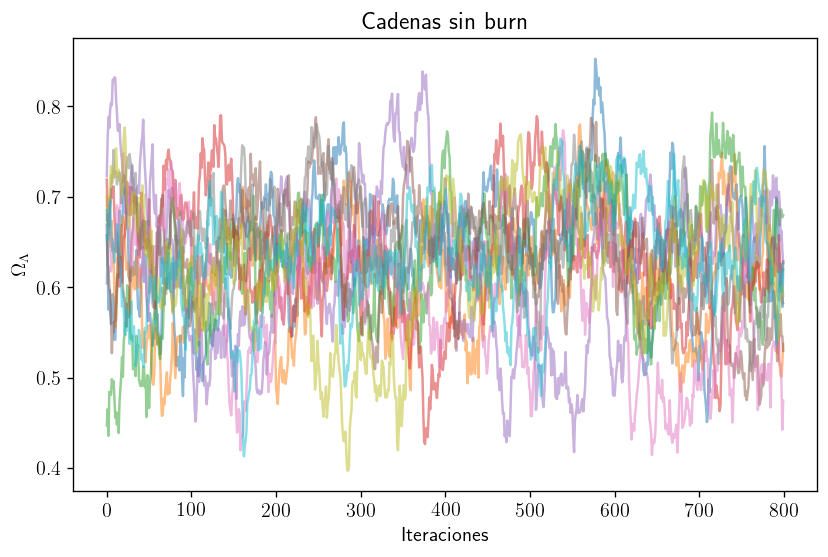

In [186]:
chains_astmu_nb = chains_astmu.T[200:].T

param_names = [r"$\Omega_\Lambda$"]

fig, ax = plt.subplots(chains_astmu.shape[1],figsize=(8,5), dpi=120)
for i in range(chains_astmu.shape[1]):
    for j in range(chains_astmu.shape[0]):
        ax.plot(range(len(chains_astmu_nb[j][i])),chains_astmu_nb[j][i],alpha=0.5)
    ax.set_ylabel(param_names[i])

ax.set_xlabel('Iteraciones')
ax.set_title('Cadenas sin burn')

In [187]:
chains_astmu_concat = np.array([0])
for i in range(len(chains_astmu_nb)):
    chains_astmu_concat = np.vstack([chains_astmu_concat,chains_astmu_nb[i].T])
chains_astmu_concat = np.array(chains_astmu_concat[1:])

Removed no burn in


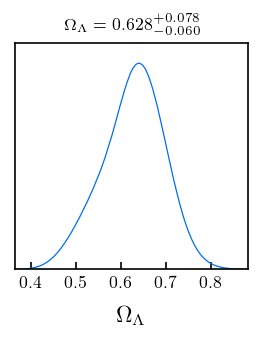

In [188]:
#Gráfica triangular
samples = MCSamples(samples=np.array(chains_astmu_concat), names=['om_l'], labels=['\Omega_\Lambda'])
plt.rcParams['figure.dpi'] = 150
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True,title_limit=1)

In [189]:
samples.means

array([0.62751787])

In [190]:
# density parameters L-CDM
om_l0 = samples.means

# Get L-CDM mu(z) function
mu_fit, z_fit = mu_z(om_m0, om_l0)

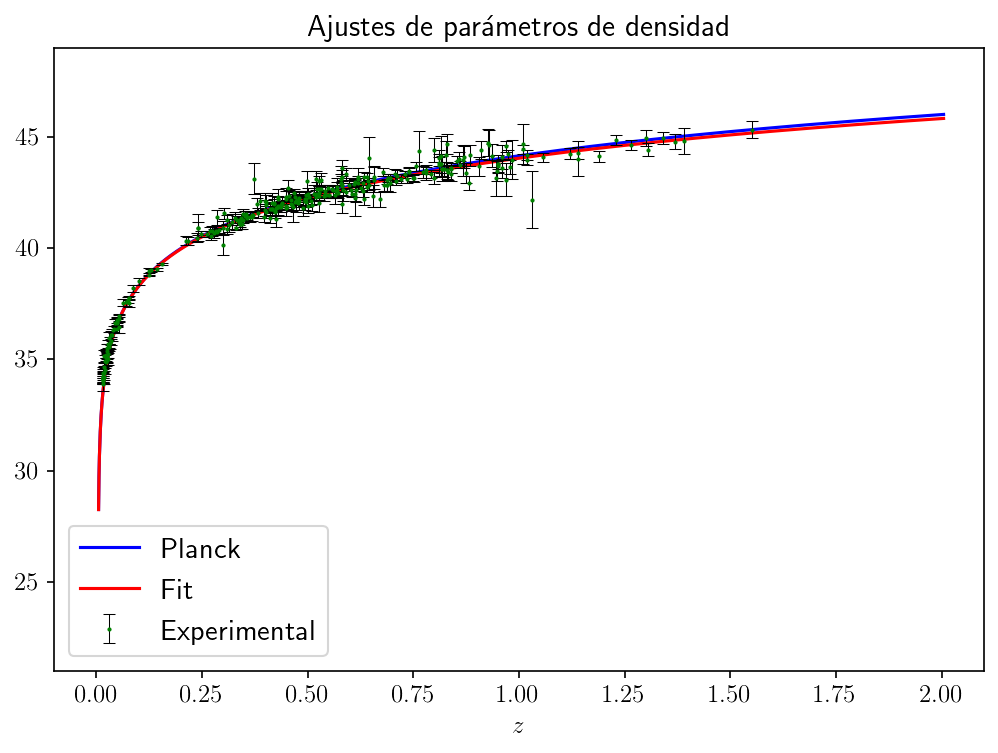

In [191]:
fig,ax = plt.subplots(figsize=(8,5.5),dpi=150)

ax.plot(z_lcdm,mu_lcdm,"b",label=r"Planck")
ax.plot(z_fit,mu_fit,"r",label=r"Fit")
ax.errorbar(z_exp,mu_exp,yerr=error_exp,fmt='g.',elinewidth=0.5,capthick=0.5,capsize=3,ecolor="k",ms=2,label=r"Experimental")

ax.set_ylim(21,49)
ax.set_xlim(-0.1,2.1)

#ax.grid()
ax.set_xlabel(r"$z$")
#ax.set_ylabel(r"1/years")
ax.set_title(r"Ajustes de parámetros de densidad")
plt.legend(fontsize=14)